In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler


In [2]:
df_wine = pd.read_csv("data/wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df_wine.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df_diabetes = pd.read_csv("data/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# WINE

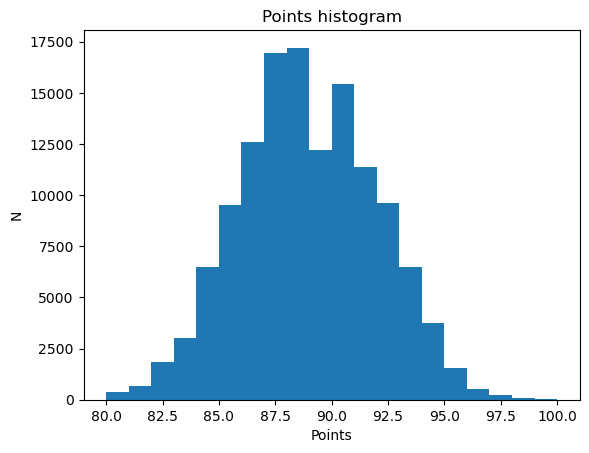

In [4]:
plt.hist(df_wine.points, bins=20)
plt.title("Points histogram")
plt.xlabel("Points")
plt.ylabel("N")
plt.show()

In [5]:
df_wine["label"] = (df_wine.points >= 90).astype(int)
df_wine = df_wine[["description", "label"]]
df_wine.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [6]:
train, valid, test = np.split(df_wine.sample(frac=1), [int(0.8*len(df_wine)), int(0.9*len(df_wine))])

In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds
    

In [8]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

print(train)
print(train_data)

                                              description  label
100543  This is rich, showing the full-bodied characte...      1
104147  A pale salmon color, this rosé shows ripe note...      0
103590  Whiffs of tea leaves and tobacco lend earthine...      0
82288   Made from 100% Montepulciano, this opens with ...      0
115003  Aromas of well-toasted oak, cinnamon, crushed ...      1
...                                                   ...    ...
112503  Packed with black-cherry flavors, this is a st...      0
15413   Briny citrus and grapefruit aromas are control...      0
96464   Blackberry and other fruits are presented clea...      0
51244   Tropical aromas of bath soap and scented baby ...      0
2953    Features pleasant but slightly simple flavors ...      0

[103976 rows x 2 columns]
<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
list(train_data)[0]

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b"A whiff of bergamot lends musky floral intensity to this peachy featherweight wine. It's perfumed but not at all cloying, etched finely with a lingering lace of crystalline sugar. Drink now through 2017.",
        b'This is the artist label Merlot; a firm, spicy expression of fruit from the Lewis vineyard. Threads of liquid smoke, spice and coffee are woven into the red fruits\xe2\x80\x94a mix of strawberry, raspberry and cherry flavors. Still young and sharp, it has some heat in the finish. Additional bottle age recommended.',
        b'Lively and tangy, but refreshing as it captures the new Chilean style of racy Sauvignon Blanc. The palate is spritzy, with lime, orange peel and tart apple flavors. Cleansing on the finish. Good value and purity for the money.',
        b"A good everyday Syrah. It doesn't show the richness of the single-vineyard bottlings, but it's nice and dry, with berry, cherry, grilled meat, pepper and oak fl

In [10]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)
# if this doesn't work:
# delete the folder which it says has missing files


In [11]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.13739717,  0.1034954 ,  0.24787523, ...,  0.03504148,
        -0.1579623 , -0.02409643],
       [ 0.5771363 , -0.5136718 , -0.09893722, ..., -0.12916596,
        -0.26500446,  0.08539297],
       [ 0.2636554 ,  0.1149773 , -0.04118557, ..., -0.0884668 ,
         0.05256573,  0.16913041],
       ...,
       [ 0.21211956, -0.12378976,  0.17185587, ..., -0.14372526,
        -0.06759723, -0.02103565],
       [ 0.4193794 , -0.15872976,  0.09187605, ...,  0.09016043,
         0.00219535, -0.09646599],
       [ 0.4687157 , -0.08502118,  0.22931145, ..., -0.11746553,
        -0.28339288, -0.13778989]], dtype=float32)>

In [21]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [22]:
import os

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 256

n_batches = 10

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
model.evaluate(train_data)

3250/3250 [==============================] - 3s 806us/step - loss: 0.6828 - accuracy: 0.5894


[0.6827781200408936, 0.5894437432289124]

In [25]:
model.evaluate(valid_data)

  1/407 [..............................] - ETA: 5s - loss: 0.6816 - accuracy: 0.6250

407/407 [==============================] - 0s 796us/step - loss: 0.6829 - accuracy: 0.5910


[0.6828896403312683, 0.5909825563430786]

In [26]:
history = model.fit(train_data, epochs=10, validation_data=valid_data, callbacks=[cp_callback])

Epoch 1/10
  49/3250 [..............................] - ETA: 12:43 - loss: 0.6256 - accuracy: 0.6492
Epoch 1: saving model to training_2\cp-0001.ckpt
  99/3250 [..............................] - ETA: 12:56 - loss: 0.5644 - accuracy: 0.6985
Epoch 1: saving model to training_2\cp-0001.ckpt
 149/3250 [>.............................] - ETA: 12:59 - loss: 0.5184 - accuracy: 0.7349
Epoch 1: saving model to training_2\cp-0001.ckpt
 199/3250 [>.............................] - ETA: 13:04 - loss: 0.4877 - accuracy: 0.7572
Epoch 1: saving model to training_2\cp-0001.ckpt
 249/3250 [=>............................] - ETA: 13:01 - loss: 0.4666 - accuracy: 0.7728
Epoch 1: saving model to training_2\cp-0001.ckpt
 299/3250 [=>............................] - ETA: 12:55 - loss: 0.4502 - accuracy: 0.7834
Epoch 1: saving model to training_2\cp-0001.ckpt
 349/3250 [==>...........................] - ETA: 12:46 - loss: 0.4408 - accuracy: 0.7914
Epoch 1: saving model to training_2\cp-0001.ckpt
 399/3250 [==>..

In [17]:
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [27]:
model.evaluate(test_data)

407/407 [==============================] - 0s 1ms/step - loss: 0.5290 - accuracy: 0.8578


[0.5289652943611145, 0.8578242659568787]

In [30]:
# save model in file to load at a later date
# model.save("model2.h5")
# model.save_weights("model2_weights")

# load model from file
latest = tf.train.latest_checkpoint(checkpoint_dir="training_2")
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(16, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid")) 
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model2.load_weights(latest)
model2.evaluate(test_data)

407/407 [==============================] - 1s 882us/step - loss: 0.3781 - accuracy: 0.8301


[0.3781324625015259, 0.8300507664680481]

In [28]:
print(history.history)

{'loss': [0.3324122726917267, 0.2681215703487396, 0.24355868995189667, 0.2258804440498352, 0.2094784379005432, 0.19912949204444885, 0.18885673582553864, 0.18174205720424652, 0.1762508600950241, 0.16959495842456818], 'accuracy': [0.8504077792167664, 0.8778468370437622, 0.8850696086883545, 0.8905516862869263, 0.8953700661659241, 0.8994768261909485, 0.9018331170082092, 0.9031122326850891, 0.9046702980995178, 0.9062283635139465], 'val_loss': [0.2687295377254486, 0.27429133653640747, 0.2826193869113922, 0.30278801918029785, 0.32661446928977966, 0.3544144928455353, 0.3848382532596588, 0.4205072224140167, 0.4436027705669403, 0.5073293447494507], 'val_accuracy': [0.8751250505447388, 0.8738939762115479, 0.8740478754043579, 0.8702777624130249, 0.8682003617286682, 0.8679695129394531, 0.8640455603599548, 0.8618912100791931, 0.8602754473686218, 0.8590443730354309]}


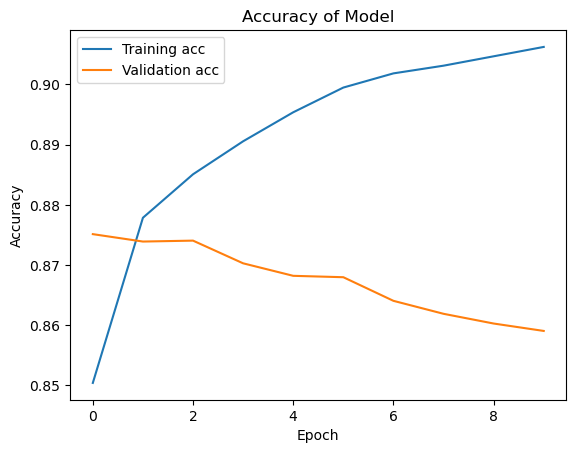

In [29]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

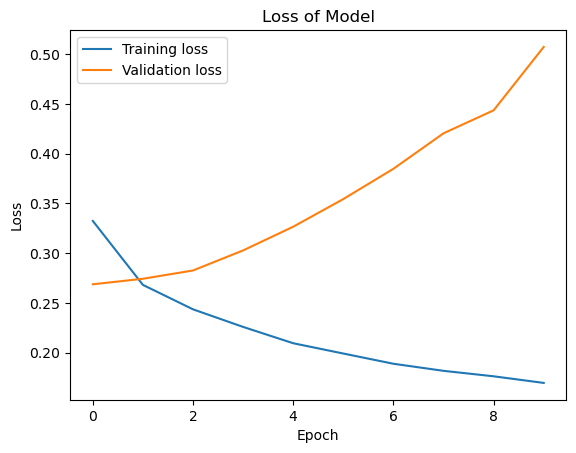

In [30]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# LSTM


In [31]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [32]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [33]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True,
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
model.evaluate(train_data)
model.evaluate(valid_data)

407/407 [==============================] - 2s 4ms/step - loss: 0.6926 - accuracy: 0.5904


[0.6926168203353882, 0.5904439687728882]

In [36]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
3250/3250 [==============================] - 48s 14ms/step - loss: 0.3971 - accuracy: 0.8179 - val_loss: 0.3560 - val_accuracy: 0.8369
Epoch 2/5
3250/3250 [==============================] - 47s 14ms/step - loss: 0.3534 - accuracy: 0.8413 - val_loss: 0.3514 - val_accuracy: 0.8377
Epoch 3/5
3250/3250 [==============================] - 42s 13ms/step - loss: 0.3397 - accuracy: 0.8468 - val_loss: 0.3536 - val_accuracy: 0.8376
Epoch 4/5
3250/3250 [==============================] - 42s 13ms/step - loss: 0.3276 - accuracy: 0.8512 - val_loss: 0.3558 - val_accuracy: 0.8391
Epoch 5/5
3250/3250 [==============================] - 43s 13ms/step - loss: 0.3182 - accuracy: 0.8545 - val_loss: 0.3600 - val_accuracy: 0.8360


In [37]:
model.evaluate(test_data)

407/407 [==============================] - 2s 4ms/step - loss: 0.3502 - accuracy: 0.8429


[0.35019049048423767, 0.8428989052772522]

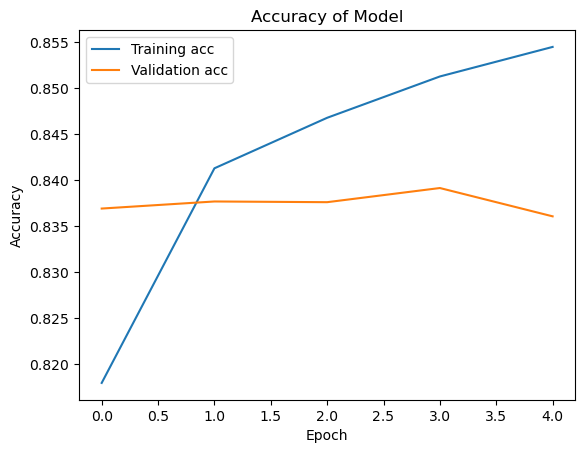

In [38]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

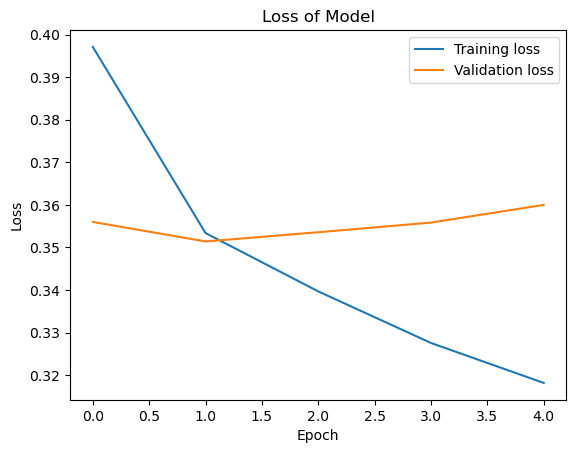

In [39]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# DIABETES

In [ ]:
for i in range(len(df_diabetes[:-1])):
    label = df_diabetes.columns[i]
    plt.hist(df_diabetes[df_diabetes['Outcome']==1][label], color='red', label='Diabetes', alpha=0.7, density=True, bins=15)
    plt.hist(df_diabetes[df_diabetes['Outcome']==0][label], color='green', label='No Diabetes', alpha=0.7, density=True, bins=15)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('N')
    plt.legend()
    plt.show()

In [ ]:
X = df_diabetes[df_diabetes.columns[:-1]].values
y = df_diabetes[df_diabetes.columns[-1]].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)

In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(268, 500)

In [ ]:
over = RandomOverSampler()
X, y = over.fit_resample(X, y)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)


In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(500, 500)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(X_train, y_train)

19/19 [==============================] - 0s 999us/step - loss: 0.7495 - accuracy: 0.3883


[0.7494762539863586, 0.3883333206176758]

In [ ]:
model.evaluate(X_valid, y_valid)

16/16 [==============================] - 0s 604us/step - loss: 0.7478 - accuracy: 0.4020


[0.7477594017982483, 0.4020000100135803]

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=32, validation_data=(X_valid, y_valid))

Epoch 1/32
38/38 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6583 - val_loss: 0.6464 - val_accuracy: 0.6680
Epoch 2/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6470 - accuracy: 0.6583 - val_loss: 0.6451 - val_accuracy: 0.6680
Epoch 3/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6600 - val_loss: 0.6438 - val_accuracy: 0.6760
Epoch 4/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6444 - accuracy: 0.6667 - val_loss: 0.6425 - val_accuracy: 0.6740
Epoch 5/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6431 - accuracy: 0.6667 - val_loss: 0.6413 - val_accuracy: 0.6760
Epoch 6/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6667 - val_loss: 0.6401 - val_accuracy: 0.6780
Epoch 7/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6683 - val_loss: 0.6389 - val_accuracy: 0.6800
Epoch 8/32
38/38 [==

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 733us/step - loss: 0.6376 - accuracy: 0.6360


[0.6375736594200134, 0.6359999775886536]